In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from time import time
import pickle
import logging
import time
from astropy.table import Table
from matplotlib import pyplot as plt

import orpheus
import treecorr

## Load in mock and result from direct estimator

In [13]:
dotomo=True
fthin = 1
data = Table.read("/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits")
pos1 = data["x_arcmin"].data
pos2 = data["y_arcmin"].data
gamma1 = data["shear1"].data
gamma2 = data["shear2"].data
e1 = data["eps_obs1"].data
e2 = data["eps_obs2"].data
zspec = data["z_spectroscopic"].data
zphot = data["z_photometric"].data
zbin = np.zeros(len(pos1),dtype=np.int32)
if dotomo:
    zbin[zphot<=0.25] = 0 
    zbin[(zphot>0.25)*(zphot<=0.5)] = 1
    zbin[(zphot>0.5)*(zphot<=0.75)] = 2
    zbin[(zphot>0.75)*(zphot<=1.)] = 3
    zbin[zphot>1.] = 4

## Get data from direct estimator as "ground truth"

In [14]:
with open("/cosma7/data/dp004/dc-port3/Analysis/ApertureMass/SLICS/KiDS450_CroppedUnmasked_Noiseless_FixedR_InvShot_C02_Acc1p0/results_batched.pickle", "rb") as input_file:
    dirdata = pickle.load(input_file)
map3R = dirdata["result_1.pickle"]['Pars']['radii']
map3_direct = dirdata["result_1.pickle"]['Meas']["Map_3"][0]

In [4]:
with open("/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/SLICS/KiDS450_Unmasked_NoPatches_Noiseless_0p3125_160p0_growth1p05_nmax20/resultggg_1.pickle", "rb") as input_file:
    oldestdata = pickle.load(input_file)
map3_fftnpcf_R = oldestdata["Map3"]['Fine']["R"]
map3_fftnpcf_noec = oldestdata["Map3"]['Fine']["Map3"]
map3_fftnpcf = oldestdata["Map3"]['Fine']["Map3_ec"]

In [640]:
tmpdata['3pcf']['multipoles_ec'].shape

(4, 21, 1, 126, 126)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

(0.9, 1.1)

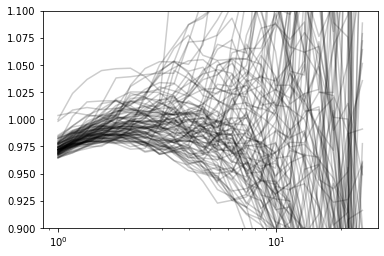

In [625]:
for i in range(1,100):
    sys.stdout.write("%i "%i)
    thismeas_dir = dirdata["result_%i.pickle"%i]["Meas"]["Map_3"][0]
    with open("/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/SLICS/KiDS450_Unmasked_NoPatches_Noiseless_0p3125_160p0_growth1p05_nmax20/resultggg_%i.pickle"%i, "rb") as input_file:
        tmpdata = pickle.load(input_file)
    thismeas_ffnpcf_noec = tmpdata["Map3"]['Dircompare']["Map3"]
    thismeas_ffnpcf = tmpdata["Map3"]['Dircompare']["Map3_ec"]
    plt.semilogx(map3R[9:], thismeas_ffnpcf[0,0]/thismeas_dir[9:],"k-",alpha=0.2)
plt.ylim(.9,1.1)
    

## Run analysis with orpheus

In [15]:
# Parameters
n_cfs = 4 # We use all correlation functions Gamma0-Gamma3
min_sep = 0.3125 # Smallest separation considered
#max_sep_disc = 5. # Smallest separ
max_sep = 200. # Largest separation considered
binsize=.1
rmin_pixsize=20 # Accuracy setting - smallest allowed value for theta_3pcf/d_pixel in reduced catalogs
dpixs = [0.,0.25,0.5,1.0,2.0,4.0] # Pixel sizes of the reduced catalogs
method = "DoubleTree" # Approximate algorithm chosen -- this is basically a low-memory implementation of the combinend estimator introduced in 2309.08601
nthreads = 16

In [16]:
# Load in catalog and define 3pcf object
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1[::fthin], pos2=pos2[::fthin], 
                                          tracer_1=gamma1[::fthin], tracer_2=gamma2[::fthin], zbins=zbin[::fthin])
threepcf_orpheus = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=max_sep, tree_resos=dpixs, multicountcorr=True,
                                          binsize=binsize, rmin_pixsize=rmin_pixsize,  method=method)
threepcf_orpheus_noec = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=max_sep, tree_resos=dpixs, multicountcorr=True,
                                          binsize=binsize, rmin_pixsize=rmin_pixsize,  method=method)
threepcf_orpheus_dpix10 = orpheus.GGGCorrelation(n_cfs=n_cfs, min_sep=min_sep, max_sep=max_sep, tree_resos=dpixs, multicountcorr=True,
                                          binsize=binsize, rmin_pixsize=10,  method=method)
print("We have %i galaxies in the mock catalog"%slicsfullreso.ngal)

We have 3070801 galaxies in the mock catalog


In [ ]:
## Timing for min_sep = 0.3125, max_sep = 200., binsize=.1, dpixs = [0.,0.25,0.5,1.0,2.0,4.0], nthreads=16, rmin_pixsize=20
# We have contributions: Gnalloc, Gncache, Ups_equal, Ups_unequal
# Full calc --> 11.69
# No Ups_equal --> 9.42 min (8.12 +no atan)
# No Ups_unequal --> 11.08 min
# No Gncache --> 8.82 min 
# Only Gnalloc --> 5.52 min (4.2 no atan; 2.4 min no atan+rmin_pixsize=15)
# Only n==0 Gn(2)alloc --> 2.8 min (1.43 no atan)
# Just up before n==0 Gnalloc --> 1.0 min (no atan)
# Only search bit of Gnalloc --> 0.1 min
# Only single Gnache --> 8.3 (no atan + no zeros)
# Not anything fancy --> 0.1 min
# --> Gncache: 3min, Gnalloc: 4.5 min, Ups_equal: 2.5 min, Ups_unequal: 0.9 min, Nothing fancy: 0.1 min
# For 5 tomobins we need 137 min on 16 cores
t1_noec = time.time()
threepcf_orpheus_noec.process(slicsfullreso, nthreads=nthreads, dotomo=dotomo, apply_edge_correction=False)
t2_noec = time.time()

Doing multihash
[0.25 0.5  1.   2.   4.  ]
First spatialhash
Doing reso 0
Done reso 0
Doing reso 1
Done reso 1
Doing reso 2
Done reso 2
Doing reso 3
Done reso 3
Doing reso 4
Done reso 4
Done multihash
[0.2499999  0.4999998  0.99999959 1.99999919 3.99999837] [3070801, 2883784, 2413846, 1366139, 440290, 112500] 6
Doing Tree


In [18]:
(t2_noec-t1_noec)/60

137.0153946876526

In [7]:
t1_ec = time.time()
threepcf_orpheus.process(slicsfullreso, nthreads=nthreads, dotomo=dotomo, apply_edge_correction=True)
t2_ec = time.time()

Doing multihash
[0.25 0.5  1.   2.   4.  ]
First spatialhash
Doing reso 0
Done reso 0
Doing reso 1
Done reso 1
Doing reso 2
Done reso 2
Doing reso 3
Done reso 3
Doing reso 4
Done reso 4
Done multihash
[0.2499999  0.4999998  0.99999959 1.99999919 3.99999837] [3070801, 2380229, 1269015, 359921, 90000, 22500] 6
Doing Tree


In [36]:
t1_d10 = time.time()
threepcf_orpheus_dpix10.process(slicsfullreso, nthreads=nthreads, dotomo=dotomo, apply_edge_correction=True)
t2_d10 = time.time()

Doing multihash
[0.25 0.5  1.   2.   4.  ]
First spatialhash
Doing reso 0
Done reso 0
Doing reso 1
Done reso 1
Doing reso 2
Done reso 2
Doing reso 3
Done reso 3
Doing reso 4
Done reso 4
Done multihash
[0.2499999  0.4999998  0.99999959 1.99999919 3.99999837] [3070801, 2380229, 1269015, 359921, 90000, 22500] 6
Doing Tree


In [24]:
#map3_orpheus = threepcf_orpheus.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)
map3_orpheus_noec = threepcf_orpheus_noec.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)
#map3_orpheus_dpix10 = threepcf_orpheus_dpix10.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)

In [457]:
threepcf_orpheus.npcf = threepcf_orpheus.npcf[[0,1,3,2]]
map3_orpheus_shuff = threepcf_orpheus.computeMap3(radii=map3R, do_multiscale=False, tofile=False, filtercache=None)
threepcf_orpheus.npcf = threepcf_orpheus.npcf[[0,1,3,2]]

In [459]:
threepcf_orpheus.npcf = threepcf_orpheus.npcf[[0,1,3,2]]

## Now run the same analysis with TreeCorr
Here I just copy the same steps that are done in the `test_ggg.py` in TreeCorr

In [12]:
# Load in data and define 3pcf object
cat = treecorr.Catalog(x=pos1[::fthin], y=pos2[::fthin], g1=gamma1[::fthin], g2=gamma2[::fthin], verbose=2)
threepcf_tcx = treecorr.GGGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, max_n=threepcf_orpheus.nmax, 
                                       verbose=2, num_threads=nthreads, bin_type='LogMultipole')

   nobj = 3070801
r: nbins = 65, min,max sep = 0.3125..200, bin_size = 0.0994072


In [13]:
t1_tc = time.time()
threepcf_tcx.process(cat)
t2_tc = time.time()

Starting process GGG auto-correlations
Using 16 threads.
Building GField
Starting 256 jobs.
varg = 0.000181: sig_g = 0.013439


In [14]:
threepcf_tc = threepcf_tcx.toSAS(phi_bin_size=0.05)

r: nbins = 65, min,max sep = 0.3125..200, bin_size = 0.0994072


In [15]:
map3_tc = threepcf_tc.calculateMap3(R=map3R)

## Transform the Orpheus multipoles to SAS via TreeCorr

Note that we seem to have some different conventions -- namely an minus sign in the $\Upsilon_n$, as well as that our $\Upsilon_2$ is TreeCorrs $\Upsilon_3$ and vice versa

In [10]:
def orpheus2treecorr(upsilon_n, norm_n, nmax, bin_edges, bin_centers, bin_size_orpheus):
    treecorrinst = treecorr.GGGCorrelation(bin_size=bin_size_orpheus, # Same as for Orpheus initialization
                                           min_sep=bin_edges[0], 
                                           max_sep=bin_edges[-1], 
                                           max_n=nmax, 
                                           bin_type='LogMultipole')
    
    nbinsr = len(bin_centers)
    
    # Copy the relevant results from Orpheus
    # [Orpheus uses some symmetry properties of the Upsilon_n/N_n, such that only multipoles>=0 need to be allocated 
    #  -- cf. (A.6) in 2309.08601. Here, we restore the n<0 multipoles and store them in the GGGCorrelation instance.]
    _baseshape = (nbinsr,nbinsr,2*nmax+1)
    _gam0 = np.zeros(_baseshape, dtype=complex)
    _gam1 = np.zeros(_baseshape, dtype=complex)
    _gam2 = np.zeros(_baseshape, dtype=complex)
    _gam3 =np.zeros(_baseshape, dtype=complex)
    _weight = np.zeros(_baseshape, dtype=complex)
    _gam0[:,:,nmax:] = -upsilon_n[0,:,0].transpose((1,2,0))
    _gam0[:,:,:nmax] = -upsilon_n[0,1:,0].transpose((2,1,0))[:,:,::-1]
    _gam1[:,:,nmax:] = -upsilon_n[1,:,0].transpose((1,2,0))
    _gam1[:,:,:nmax] = -upsilon_n[1,1:,0].transpose((2,1,0))[:,:,::-1]
    _gam2[:,:,nmax:] = -upsilon_n[3,:,0].transpose((1,2,0))
    _gam2[:,:,:nmax] = -upsilon_n[2,1:,0].transpose((2,1,0))[:,:,::-1]
    _gam3[:,:,nmax:] = -upsilon_n[2,:,0].transpose((1,2,0))
    _gam3[:,:,:nmax] = -upsilon_n[3,1:,0].transpose((2,1,0))[:,:,::-1]
    _weight[:,:,nmax:] = norm_n[:,0].transpose((1,2,0))
    _weight[:,:,:nmax] = norm_n[1:,0].transpose((2,1,0))[:,:,::-1]
    treecorrinst.gam0r = _gam0.real
    treecorrinst.gam0i = _gam0.imag
    treecorrinst.gam1r = _gam1.real
    treecorrinst.gam1i = _gam1.imag
    treecorrinst.gam2r = _gam2.real
    treecorrinst.gam2i = _gam2.imag
    treecorrinst.gam3r = _gam3.real
    treecorrinst.gam3i = _gam3.imag
    treecorrinst.weightr = _weight.real
    treecorrinst.weighti = _weight.imag
    
    # [Orpheus just uses mean bin centers at the moment -- so I just copy those values to all the (theta1,theta2) combinations]
    treecorrinst.meand3 = np.zeros(_baseshape, dtype=float)
    treecorrinst.meand2 = np.zeros(_baseshape, dtype=float)
    for i in range(nbinsr):
        treecorrinst.meand2[i,:,:] = bin_centers[i]
        treecorrinst.meand3[:,i,:] = bin_centers[i]
    treecorrinst.meanlogd2 = np.log(treecorrinst.meand2)
    treecorrinst.meanlogd3 = np.log(treecorrinst.meand3)
    
    # Transform to SAS
    sas_treecorrinst = treecorrinst.toSAS()
    
    return sas_treecorrinst

#nexttcinst = orpheus2treecorr(tmpdata['3pcf']['multipoles_ec'], tmpdata['3pcf']['norms'], 20, tmpdata["3pcf"]["edges"], tmpdata["3pcf"]["centers"], 1.05) 
#nextmap3 = nexttcinst.calculateMap3(R=map3R)


In [753]:
los_max = 3
allmap3_direct = [None]*los_max
allmap3_fftnpcf = [None]*los_max
allmap3_jbj = [None]*los_max

for los in range(1,los_max+1):
    sys.stdout.write("%i "%los)
    #if los==1:
    #    with open("/cosma7/data/dp004/dc-port3/Analysis/ApertureMass/SLICS/KiDS450_CroppedUnmasked_Noiseless_FixedR_InvShot_C02_Acc1p0/results_batched.pickle", "rb") as input_file:
    #        dirdata = pickle.load(input_file)
    #map3R = dirdata["result_%i.pickle"%los]['Pars']['radii']
    map3_direct = dirdata["result_%i.pickle"%los]['Meas']["Map_3"][0]

    with open("/cosma7/data/dp004/dc-port3/Analysis/NPOINTFFT/SLICS/KiDS450_Unmasked_NoPatches_Noisy_0p3125_160p0_growth1p1_nmax20/resultggg_%i.pickle"%los, "rb") as input_file:
        oldestdata = pickle.load(input_file)
    map3_fftnpcf_noec = oldestdata["Map3"]['Dircompare']["Map3"]

    nexttcinst = orpheus2treecorr(upsilon_n=oldestdata['3pcf']['multipoles_ec'], 
                                  norm_n=oldestdata['3pcf']['norms'],
                                  nmax=20, 
                                  bin_edges=oldestdata["3pcf"]["edges"], 
                                  bin_centers=oldestdata["3pcf"]["centers"], 
                                  bin_size_orpheus=0.098) 
    nextmap3 = nexttcinst.calculateMap3(R=map3R)
    
    allmap3_direct[los-1] = map3_direct
    allmap3_fftnpcf[los-1] = map3_fftnpcf_noec[0,0]
    allmap3_jbj[los-1] = np.sqrt(2)*nextmap3[0]
    
    

#plt.semilogx(map3R, np.sqrt(2)*nextmap3[0], label="tc")
#plt.semilogx(map3R[9:], map3_fftnpcf_noec[0,0], label="fftnpcf")
#plt.semilogx(map3R, map3_direct, label="Direct")
#plt.legend()
#oldestdata["Map3"]['Dircompare']["R"]

1 2 3 

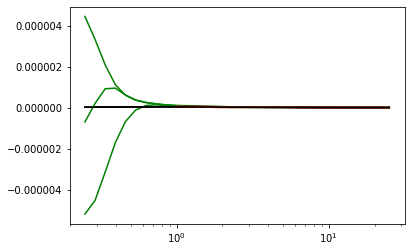

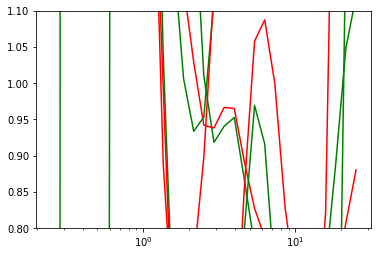

In [754]:
for i in range(los_max):
    plt.semilogx(map3R, allmap3_jbj[i], "g-")
    plt.semilogx(map3R[9:], allmap3_fftnpcf[i], "r-")
    plt.semilogx(map3R, allmap3_direct[i], "k-")
plt.show()

for i in range(los_max):
    plt.semilogx(map3R, allmap3_jbj[i]/allmap3_direct[i], "g-")
    plt.semilogx(map3R[9:], allmap3_fftnpcf[i]/allmap3_direct[i][9:],"r-")
plt.ylim(.8,1.1)
plt.show()

In [19]:
thisorpheusinst = threepcf_orpheus_noec
# Initalize new GGGCorrelation instance using the same binning etc as was used for the Orpheus run
# [We need to make sure that Orpheus and TreeCorr adjust the bin_size parameter in the same way]
threepcf_tcxfromorpheus = treecorr.GGGCorrelation(bin_size=0.1, # Same as for Orpheus initialization
                                                  min_sep=thisorpheusinst.min_sep, 
                                                  max_sep=thisorpheusinst.max_sep, 
                                                  max_n=thisorpheusinst.nmax, 
                                                  num_threads=nthreads, bin_type='LogMultipole')
print("Inferred bin_size for TreeCorr: %.10f"%threepcf_tcxfromorpheus.bin_size)
print("Inferred bin_size for Orpheus : %.10f"%thisorpheusinst.binsize)

# Copy the relevant results from Orpheus
# [Orpheus uses some symmetry properties of the Upsilon_n/N_n, such that only multipoles>=0 need to be allocated 
#  -- cf. (A.6) in 2309.08601. Here, we restore the n<0 multipoles and store them in the GGGCorrelation instance.]
_baseshape = (thisorpheusinst.nbinsr,thisorpheusinst.nbinsr,2*thisorpheusinst.nmax+1)
_gam0 = np.zeros(_baseshape, dtype=complex)
_gam1 = np.zeros(_baseshape, dtype=complex)
_gam2 = np.zeros(_baseshape, dtype=complex)
_gam3 =np.zeros(_baseshape, dtype=complex)
_weight = np.zeros(_baseshape, dtype=complex)
_gam0[:,:,thisorpheusinst.nmax:] = -thisorpheusinst.npcf_multipoles[0,:,0].transpose((1,2,0))
_gam0[:,:,:thisorpheusinst.nmax] = -thisorpheusinst.npcf_multipoles[0,1:,0].transpose((2,1,0))[:,:,::-1]
_gam1[:,:,thisorpheusinst.nmax:] = -thisorpheusinst.npcf_multipoles[1,:,0].transpose((1,2,0))
_gam1[:,:,:thisorpheusinst.nmax] = -thisorpheusinst.npcf_multipoles[1,1:,0].transpose((2,1,0))[:,:,::-1]
_gam2[:,:,thisorpheusinst.nmax:] = -thisorpheusinst.npcf_multipoles[3,:,0].transpose((1,2,0))
_gam2[:,:,:thisorpheusinst.nmax] = -thisorpheusinst.npcf_multipoles[2,1:,0].transpose((2,1,0))[:,:,::-1]
_gam3[:,:,thisorpheusinst.nmax:] = -thisorpheusinst.npcf_multipoles[2,:,0].transpose((1,2,0))
_gam3[:,:,:thisorpheusinst.nmax] = -thisorpheusinst.npcf_multipoles[3,1:,0].transpose((2,1,0))[:,:,::-1]
_weight[:,:,thisorpheusinst.nmax:] = thisorpheusinst.npcf_multipoles_norm[:,0].transpose((1,2,0))
_weight[:,:,:thisorpheusinst.nmax] = thisorpheusinst.npcf_multipoles_norm[1:,0].transpose((2,1,0))[:,:,::-1]
threepcf_tcxfromorpheus.gam0r = _gam0.real
threepcf_tcxfromorpheus.gam0i = _gam0.imag
threepcf_tcxfromorpheus.gam1r = _gam1.real
threepcf_tcxfromorpheus.gam1i = _gam1.imag
threepcf_tcxfromorpheus.gam2r = _gam2.real
threepcf_tcxfromorpheus.gam2i = _gam2.imag
threepcf_tcxfromorpheus.gam3r = _gam3.real
threepcf_tcxfromorpheus.gam3i = _gam3.imag
threepcf_tcxfromorpheus.weightr = _weight.real
threepcf_tcxfromorpheus.weighti = _weight.imag

# [Orpheus just uses mean bin centers at the moment -- so I just copy those values to all the (theta1,theta2) combinations]
threepcf_tcxfromorpheus.meand3 = np.zeros(_baseshape, dtype=float)
threepcf_tcxfromorpheus.meand2 = np.zeros(_baseshape, dtype=float)
for i in range(thisorpheusinst.nbinsr):
    threepcf_tcxfromorpheus.meand2[i,:,:] = thisorpheusinst.bin_centers_mean[i]
    threepcf_tcxfromorpheus.meand3[:,i,:] = thisorpheusinst.bin_centers_mean[i]
threepcf_tcxfromorpheus.meanlogd2 = np.log(threepcf_tcxfromorpheus.meand2)
threepcf_tcxfromorpheus.meanlogd3 = np.log(threepcf_tcxfromorpheus.meand3)

# Transform to SAS
threepcf_tcfromorpheus = threepcf_tcxfromorpheus.toSAS(phi_bin_size=0.05)

# Compute Map3
map3_tcfromorpheus = threepcf_tcfromorpheus.calculateMap3(R=map3R)

Inferred bin_size for TreeCorr: 0.0994072027
Inferred bin_size for Orpheus : 0.0994072027


## Compare results with direct estimator

Note that we do not expect perfect agreement between both methods on large & small scales. 
* On small scales we know that there is bias in the 3pcf estimator as the correlation function is only computed down to some minimum distance $\theta_{\rm min}=0.'3125$ -- this translates to a suppression of the signal for aperture radii $\lesssim 1.'5$.
* The direct estimator needs to cut off the outer strips of the survey data, meaning that for large aperture radii it probes not all possible triangle configurations.

In [21]:
time_orpheus = (t2_noec-t1_noec)/60.
#time_orpheus10 = (t2_d10-t1_d10)/60.
time_treecorr = (t2_tc-t1_tc)/60.
print("Time taken for TreeCorr: %.2f min"%(time_treecorr))
print("Time taken for Orpheus: %.2f min"%(time_orpheus))
#print("Time taken for Orpheus (dpix10): %.2f min"%(time_orpheus10))

Time taken for TreeCorr: 22.55 min
Time taken for Orpheus: 13.29 min


In [22]:
threepcf_tcfromorpheus.d3nom[0,:,0]

array([  0.32842486,   0.3627505 ,   0.40066372,   0.44253948,
         0.48879192,   0.53987848,   0.59630441,   0.65862774,
         0.72746486,   0.80349655,   0.88747477,   0.98023006,
         1.08267976,   1.19583708,   1.32082115,   1.45886806,
         1.61134307,   1.77975415,   1.96576688,   2.17122092,
         2.39814818,   2.64879296,   2.92563412,   3.23140961,
         3.56914352,   3.94217602,   4.35419637,   4.80927942,
         5.31192593,   5.86710702,   6.4803134 ,   7.15760964,
         7.90569415,   8.73196544,   9.64459528,  10.65260951,
        11.76597732,  12.99570986,  14.35396908,  15.85418808,
        17.51120392,  19.34140438,  21.36289002,  23.59565319,
        26.06177577,  28.78564754,  31.79420741,  35.11720984,
        38.78751908,  42.84143426,  47.31904831,  52.26464454,
        57.72713456,  63.76054202,  70.42453691,  77.78502569,
        85.91480309,  94.89427206, 104.81223895, 115.76679176,
       127.86627028, 141.23033754, 155.99116324, 172.29

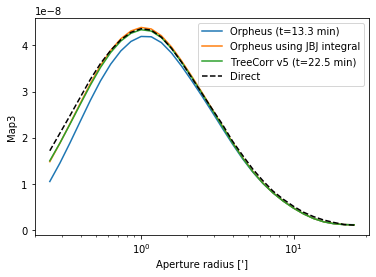

(0.9, 1.1)

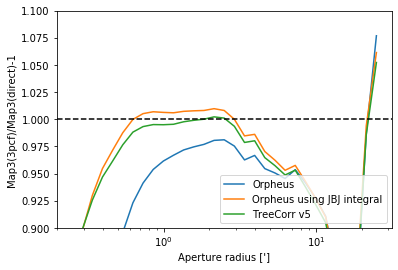

In [25]:
plt.semilogx(map3R, map3_orpheus_noec[0,0].real, label="Orpheus (t=%.1f min)"%time_orpheus)
plt.semilogx(map3R, np.sqrt(2)*map3_tcfromorpheus[0], label="Orpheus using JBJ integral")
plt.semilogx(map3R, np.sqrt(2)*map3_tc[0], label="TreeCorr v5 (t=%.1f min)"%time_treecorr)
plt.semilogx(map3R, map3_direct, "k--", label="Direct")
plt.xlabel("Aperture radius [']")
plt.ylabel("Map3")
plt.legend()
plt.show()

plt.semilogx(map3R, map3_orpheus_noec[0,0].real/map3_direct, label="Orpheus")
plt.semilogx(map3R, np.sqrt(2)*map3_tcfromorpheus[0]/map3_direct, label="Orpheus using JBJ integral")
plt.semilogx(map3R, np.sqrt(2)*map3_tc[0].real/map3_direct, label="TreeCorr v5")
plt.axhline(1, color="k", ls="--")
plt.xlabel("Aperture radius [']")
plt.ylabel("Map3(3pcf)/Map3(direct)-1")
plt.legend(loc="lower right")
plt.ylim(.9,1.1)

In [29]:
threepcf_orpheus.edge_correction(ret_matrices=False)

In [32]:
threepcf_orpheus.npcf=None
threepcf_orpheus.npcf_norm = None
threepcf_orpheus.multipoles2npcf()

In [43]:
threepcf_orpheus_dpix10.projection

'X'

In [39]:
_orpheus_dpix10.npcf

AttributeError: 'numpy.ndarray' object has no attribute 'npcf'

In [60]:
threepcf_tcx.min_sep, threepcf_tcx.max_sep, threepcf_tcx.bin_size

(0.3125, 200.0, 0.09940720271313411)

In [63]:
threepcf_orpheus.min_sep, threepcf_orpheus.max_sep, threepcf_orpheus.binsize

(0.3125, 200.0, 0.099407202713134)

In [511]:
threepcf_tcxfromorpheus = treecorr.GGGCorrelation(bin_size=binsize, min_sep=min_sep, max_sep=max_sep, max_n=threepcf_orpheus.nmax, 
                                       verbose=2, num_threads=nthreads, bin_type='LogMultipole')

r: nbins = 65, min,max sep = 0.3125..200, bin_size = 0.0994072


In [512]:
_gam0 = np.zeros((65,65,61), dtype=complex)
_gam1 = np.zeros((65,65,61), dtype=complex)
_gam2 = np.zeros((65,65,61), dtype=complex)
_gam3 = np.zeros((65,65,61), dtype=complex)
_weight = np.zeros((65,65,61), dtype=complex)
_gam0[:,:,30:] = -threepcf_orpheus.npcf_multipoles[0,:,0].transpose((1,2,0))
_gam0[:,:,:30] = -threepcf_orpheus.npcf_multipoles[0,1:,0].transpose((2,1,0))[:,:,::-1]
_gam1[:,:,30:] = -threepcf_orpheus.npcf_multipoles[1,:,0].transpose((1,2,0))
_gam1[:,:,:30] = -threepcf_orpheus.npcf_multipoles[1,1:,0].transpose((2,1,0))[:,:,::-1]
_gam2[:,:,30:] = -threepcf_orpheus.npcf_multipoles[3,:,0].transpose((1,2,0))
_gam2[:,:,:30] = -threepcf_orpheus.npcf_multipoles[2,1:,0].transpose((2,1,0))[:,:,::-1]
_gam3[:,:,30:] = -threepcf_orpheus.npcf_multipoles[2,:,0].transpose((1,2,0))
_gam3[:,:,:30] = -threepcf_orpheus.npcf_multipoles[3,1:,0].transpose((2,1,0))[:,:,::-1]
_weight[:,:,30:] = threepcf_orpheus.npcf_multipoles_norm[:,0].transpose((1,2,0))
_weight[:,:,:30] = threepcf_orpheus.npcf_multipoles_norm[1:,0].transpose((2,1,0))[:,:,::-1]
threepcf_tcxfromorpheus.gam0r = _gam0.real
threepcf_tcxfromorpheus.gam0i = _gam0.imag
threepcf_tcxfromorpheus.gam1r = _gam1.real
threepcf_tcxfromorpheus.gam1i = _gam1.imag
threepcf_tcxfromorpheus.gam2r = _gam2.real
threepcf_tcxfromorpheus.gam2i = _gam2.imag
threepcf_tcxfromorpheus.gam3r = _gam3.real
threepcf_tcxfromorpheus.gam3i = _gam3.imag
threepcf_tcxfromorpheus.weightr = _weight.real
threepcf_tcxfromorpheus.weighti = _weight.imag


bc = np.zeros((65,65,61))
for i in range(65):
    bc[i,:,:] = threepcf_orpheus.bin_centers_mean[i]
    
threepcf_tcxfromorpheus.meand2 = threepcf_tcx.meand2
threepcf_tcxfromorpheus.meanlogd2 = threepcf_tcx.meanlogd2
threepcf_tcxfromorpheus.meand3 = threepcf_tcx.meand3
threepcf_tcxfromorpheus.meanlogd3 = threepcf_tcx.meanlogd3

#threepcf_tcxfromorpheus.logd2 = np.log(bc)
#threepcf_tcxfromorpheus.logd3 = np.log(bc)
#threepcf_tcxfromorpheus.meand1 = bc
#threepcf_tcxfromorpheus.d3nom = bc    
    

threepcf_tcfromorpheus = threepcf_tcxfromorpheus.toSAS(phi_bin_size=0.05)

r: nbins = 65, min,max sep = 0.3125..200, bin_size = 0.0994072


In [12]:
map3_tcfromorpheus = threepcf_tcfromorpheus.calculateMap3(R=map3R)

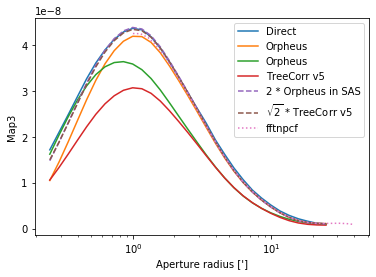

(-0.1, 0.02)

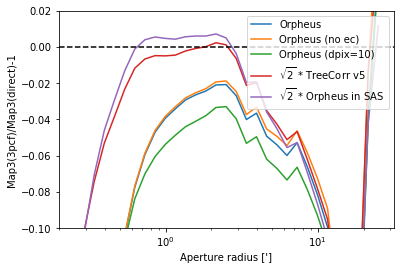

In [553]:
# Gamma01 --> x2*sqrt(2), too small at small scales
# Gamma23 --> x2*sqrt(2), too small at small scales
plt.semilogx(map3R, map3_direct, label="Direct")
plt.semilogx(map3R, map3_orpheus[0,0].real, label="Orpheus")
plt.semilogx(map3R, map3_orpheus_shuff[0,0].real, label="Orpheus")
#plt.semilogx(map3R, map3_orpheus_noec[0,0].real, label="Orpheus (no ec)")
#plt.semilogx(map3R, map3_orpheus_dpix10[0,0].real, label="Orpheus (dpix=10)")
plt.semilogx(map3R, map3_tc[0], label="TreeCorr v5")
plt.semilogx(map3R, np.sqrt(2)*map3_tcfromorpheus[0], ls="--", label="2 * Orpheus in SAS")
plt.semilogx(map3R, np.sqrt(2)*map3_tc[0], ls="--", label="$\sqrt{2}$ * TreeCorr v5")
plt.semilogx(map3_fftnpcf_R, map3_fftnpcf_noec[0,0], ls=":", label="fftnpcf")

plt.xlabel("Aperture radius [']")
plt.ylabel("Map3")
plt.legend()
plt.show()

plt.semilogx(map3R, map3_orpheus[0,0].real/map3_direct-1, label="Orpheus")
plt.semilogx(map3R, map3_orpheus_noec[0,0].real/map3_direct-1, label="Orpheus (no ec)")
plt.semilogx(map3R, map3_orpheus_dpix10[0,0].real/map3_direct-1, label="Orpheus (dpix=10)")
plt.semilogx(map3R, np.sqrt(2)*map3_tc[0].real/map3_direct-1, label="$\sqrt{2}$ * TreeCorr v5")
plt.semilogx(map3R, np.sqrt(2)*map3_tcfromorpheus[0].real/map3_direct-1, label="$\sqrt{2}$ * Orpheus in SAS")
plt.axhline(0, color="k", ls="--")
plt.xlabel("Aperture radius [']")
plt.ylabel("Map3(3pcf)/Map3(direct)-1")
plt.legend()
plt.ylim(-0.1,0.02)

In [77]:
threepcf_tcxfromorpheus?

Type:           GGGCorrelation
String form:    GGGCorrelation(config={'bin_size': 0.1, 'min_sep': 0.3125, 'max_sep': 200.0, 'max_n': 30, 'verbos <...> max_top': 10, 'precision': 4, 'metric': 'Euclidean', 'var_method': 'shot', 'num_bootstrap': 500})
File:           ~/.local/lib/python3.7/site-packages/treecorr/gggcorrelation.py
Docstring:     
This class handles the calculation and storage of a 3-point shear-shear-shear correlation
function.

We use the "natural components" of the shear 3-point function described by Schneider &
Lombardi (2003) [Astron.Astrophys. 397 (2003) 809-818].  In this paradigm, the shears
are projected relative to some point defined by the geometry of the triangle.  They
give several reasonable choices for this point.  We choose the triangle's centroid as the
"most natural" point, as many simple shear fields have purely real :math:`\Gamma_0` using
this definition.  It is also a fairly simple point to calculate in the code compared to
some of the other options the

/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/cosma/local/pythonconda3/2020-02/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


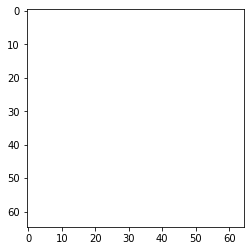

In [194]:
plt.imshow(np.log10(threepcf_tcxfromorpheus.gam0r[:,:,30]))

In [83]:
np.log(threepcf_orpheus.bin_centers_mean)

array([-1.11143665, -1.01197027, -0.91256768, -0.81315924, -0.713797  ,
       -0.61440413, -0.51495039, -0.41554113, -0.31614007, -0.21673297,
       -0.1173289 , -0.01790365,  0.08148172,  0.1808983 ,  0.28031004,
        0.37971883,  0.4791179 ,  0.57853312,  0.67793509,  0.7773417 ,
        0.87674907,  0.97616449,  1.07556021,  1.17497163,  1.27437793,
        1.37378094,  1.47319448,  1.57259856,  1.67200138,  1.77141001,
        1.87081653,  1.97021986,  2.0696272 ,  2.16903149,  2.26843666,
        2.36783978,  2.4672465 ,  2.56665245,  2.66605653,  2.76545964,
        2.86486567,  2.96427034,  3.06367699,  3.16307809,  3.26247907,
        3.36187957,  3.46128305,  3.56068529,  3.66008385,  3.75948671,
        3.8588825 ,  3.95827808,  4.05767425,  4.15707099,  4.25646636,
        4.35585719,  4.45525128,  4.55464262,  4.65402784,  4.7533987 ,
        4.85276935,  4.9521392 ,  5.05150487,  5.1508711 ,  5.25022056])

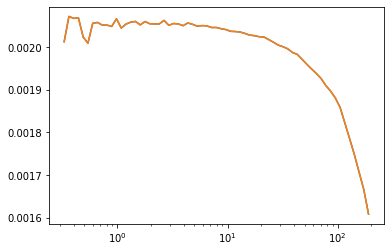

In [250]:
#plt.plot(np.unique(threepcf_tcx.logd2))
#plt.plot(np.unique(threepcf_tcx.logd3))
plt.semilogx(threepcf_orpheus.bin_centers_mean, threepcf_orpheus.bin_centers_mean/np.e**np.unique(threepcf_tcx.logd3)-1)
plt.semilogx(threepcf_orpheus.bin_centers_mean, threepcf_orpheus.bin_centers_mean/np.e**np.unique(threepcf_tcx.logd2)-1)

In [102]:
np.tile(threepcf_orpheus.bin_centers_mean, 65*61).reshape((65,65,61)).transpose((1,0,2))

array([[[  0.32908584,   0.36350208,   0.40149199, ..., 105.00708684,
         115.97778923, 128.0946386 ],
        [  0.32908584,   0.36350208,   0.40149199, ..., 105.00708684,
         115.97778923, 128.0946386 ],
        [  0.32908584,   0.36350208,   0.40149199, ..., 105.00708684,
         115.97778923, 128.0946386 ],
        ...,
        [  0.32908584,   0.36350208,   0.40149199, ..., 105.00708684,
         115.97778923, 128.0946386 ],
        [  0.32908584,   0.36350208,   0.40149199, ..., 105.00708684,
         115.97778923, 128.0946386 ],
        [  0.32908584,   0.36350208,   0.40149199, ..., 105.00708684,
         115.97778923, 128.0946386 ]],

       [[141.47728904, 156.25743537, 172.58176126, ...,  70.56020811,
          77.93360071,  86.07777752],
        [141.47728904, 156.25743537, 172.58176126, ...,  70.56020811,
          77.93360071,  86.07777752],
        [141.47728904, 156.25743537, 172.58176126, ...,  70.56020811,
          77.93360071,  86.07777752],
        ...,


In [107]:
bc = np.zeros((65,65,61))
for i in range(65):
    bc[i,:,:] = threepcf_orpheus.bin_centers_mean[i]

In [109]:
bc[0]

array([[0.32908584, 0.32908584, 0.32908584, ..., 0.32908584, 0.32908584,
        0.32908584],
       [0.32908584, 0.32908584, 0.32908584, ..., 0.32908584, 0.32908584,
        0.32908584],
       [0.32908584, 0.32908584, 0.32908584, ..., 0.32908584, 0.32908584,
        0.32908584],
       ...,
       [0.32908584, 0.32908584, 0.32908584, ..., 0.32908584, 0.32908584,
        0.32908584],
       [0.32908584, 0.32908584, 0.32908584, ..., 0.32908584, 0.32908584,
        0.32908584],
       [0.32908584, 0.32908584, 0.32908584, ..., 0.32908584, 0.32908584,
        0.32908584]])

In [159]:
for el in threepcf_tcx.__dict__.keys():
    if isinstance(threepcf_tcx.__dict__[el], np.ndarray):
        print(el)
        print(threepcf_tcx.__dict__[el].shape)
        print(len(np.unique(threepcf_tcx.__dict__[el].flatten())))

meanu
(65, 65, 61)
1
meanv
(65, 65, 61)
1
meand1
(65, 65, 61)
1
meanlogd1
(65, 65, 61)
1
meand2
(65, 65, 61)
4225
meanlogd2
(65, 65, 61)
4225
meand3
(65, 65, 61)
4225
meanlogd3
(65, 65, 61)
4225
gam0r
(65, 65, 61)
255449
gam1r
(65, 65, 61)
255408
gam2r
(65, 65, 61)
257725
gam3r
(65, 65, 61)
257725
gam0i
(65, 65, 61)
248726
gam1i
(65, 65, 61)
248547
gam2i
(65, 65, 61)
257725
gam3i
(65, 65, 61)
257725
weightr
(65, 65, 61)
66495
weighti
(65, 65, 61)
124801
ntri
(65, 65, 61)
2145


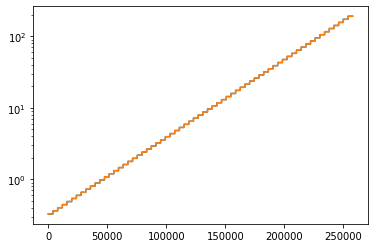

In [168]:
plt.semilogy(np.sort(threepcf_tcx.meand2.flatten()))
plt.semilogy(np.sort(threepcf_tcx.meand3.flatten()))

In [599]:
threepcf_fromorpheus.phi1d/np.pi

array([0.00795775, 0.02387324, 0.03978874, 0.05570423, 0.07161972,
       0.08753522, 0.10345071, 0.11936621, 0.1352817 , 0.1511972 ,
       0.16711269, 0.18302818, 0.19894368, 0.21485917, 0.23077467,
       0.24669016, 0.26260566, 0.27852115, 0.29443664, 0.31035214,
       0.32626763, 0.34218313, 0.35809862, 0.37401412, 0.38992961,
       0.4058451 , 0.4217606 , 0.43767609, 0.45359159, 0.46950708])

In [557]:
# rnom1d, meand2, meand3, meanphi, _phi_units, bin_size, phi_bin_size

def calculateMap3(inst, R=None, k2=1, k3=1):
    
    rnom1d = inst.bin_centers_mean
    meand2 = np.zeros((inst.nbinsr,inst.nbinsr,2*inst.nmax+1), dtype=float)
    meand3 = np.zeros((inst.nbinsr,inst.nbinsr,2*inst.nmax+1), dtype=float)
    _nphi
    meanphi = np.zeros((inst.nbinsr,inst.nbinsr,2*inst.nbinsphi[0]), dtype=float)
    for i in range(inst.nbinsr):
        meand2[i,:,:] = inst.bin_centers_mean[i]
        meand3[:,i,:] = inst.bin_centers_mean[i]
        meanphi[:,i,:] = inst.bin_centers_mean[i]
    meanlogd2 = np.log(meand2)
    meanlogd3 = np.log(meand3)
    
    
    threepcf_tcxfromorpheus.meand3 = 
threepcf_tcxfromorpheus.meand2 = np.zeros((threepcf_orpheus.nbinsr,threepcf_orpheus.nbinsr,2*threepcf_orpheus.nmax+1), dtype=float)
for i in range(threepcf_orpheus.nbinsr):
    threepcf_tcxfromorpheus.meand2[i,:,:] = threepcf_orpheus.bin_centers_mean[i]
    threepcf_tcxfromorpheus.meand3[:,i,:] = threepcf_orpheus.bin_centers_mean[i]
threepcf_tcxfromorpheus.meanlogd2 = np.log(threepcf_tcxfromorpheus.meand2)
threepcf_tcxfromorpheus.meanlogd3 = np.log(threepcf_tcxfromorpheus.meand3)


    
    sas.meand2[:,:,:] = self.meand2[:,:,0][:,:,None]
    sas.meanlogd2[:,:,:] = self.meanlogd2[:,:,0][:,:,None]
    sas.meand3[:,:,:] = self.meand3[:,:,0][:,:,None]
    sas.meanlogd3[:,:,:] = self.meanlogd3[:,:,0][:,:,None]

    # Use nominal for meanphi
    sas.meanu[:] = sas.phi / sas._phi_units
    # Compute d1 from actual d2,d3 and nominal phi
    sas.meand1[:] = np.sqrt(sas.meand2**2 + sas.meand3**2
                            - 2*sas.meand2 * sas.meand3 * np.cos(sas.phi))
    sas.meanlogd1[:] = np.log(sas.meand1)
        
        
        
    # As in the calculateMapSq function, we Make s and t matrices, so we can eventually do the
    # integral by doing a matrix product.
    if R is None:
        R = inst.rnom1d
    # Pick s = d2, so dlogs is bin_size
    s = d2 = np.outer(1./R, inst.meand2.ravel())
    d3 = np.outer(1./R, inst.meand3.ravel())
    t = d3 * np.exp(1j * inst.meanphi.ravel() * inst._phi_units)
    # Next we need to construct the T values.
    T0, T1, T2, T3 = _calculateT(s,t,1.,k2,k3)

    # In SAS binning, d2t is easier.
    # We bin directly in ln(d3) and phi, so
    # tx = d3 cos(phi)
    # ty = d3 sin(phi)
    # dtx/dlnd3 = d3 dtx/dd3 = d3 cos(phi)
    # dty/dlnd3 = d3 dty/dd3 = d3 sin(phi)
    # dtx/dphi = -d3 sin(phi)
    # dty/dphi = d3 cos(phi)
    # J(tx,ty; lnd3, phi) = d3^2
    d2t = d3**2 * inst.bin_size * inst.phi_bin_size / (2*np.pi)
    sds = s * s * inst.bin_size  # Remember bin_size is dln(s)
    # Note: these are really d2t/2piR^2 and sds/R^2, which are what actually show up
    # in JBJ equations 45 and 50.
    T0 *= sds * d2t
    T1 *= sds * d2t
    T2 *= sds * d2t
    T3 *= sds * d2t
    # Now do the integral by taking the matrix products.
    gam0 = inst.gam0.ravel()
    gam1 = inst.gam1.ravel()
    gam2 = inst.gam2.ravel()
    gam3 = inst.gam3.ravel()
    mmm = T0.dot(gam0)
    mcmm = T1.dot(gam1)
    mmcm = T2.dot(gam2)
    mmmc = T3.dot(gam3)
    
    # SAS binning counts each triangle with each vertex in the c1 position.
    # Just need to account for the cases where 1-2-3 are clockwise, rather than CCW.
    if k2 == 1 and k3 == 1:
        mmm *= 2
        mcmm *= 2
        mmcm += mmmc
        mmmc = mmcm
    else:
        # Repeat the above with 2,3 swapped.
        T0, T1, T2, T3 = _calculateT(s,t,1,k3,k2)
        T0 *= sds * d2t
        T1 *= sds * d2t
        T2 *= sds * d2t
        T3 *= sds * d2t
        mmm += T0.dot(gam0)
        mcmm += T1.dot(gam1)
        mmmc += T2.dot(gam2)
        mmcm += T3.dot(gam3)
        
    map3 = 0.25 * np.real(mcmm + mmcm + mmmc + mmm)
    mapmapmx = 0.25 * np.imag(mcmm + mmcm - mmmc + mmm)
    mapmxmap = 0.25 * np.imag(mcmm - mmcm + mmmc + mmm)
    mxmapmap = 0.25 * np.imag(-mcmm + mmcm + mmmc + mmm)
    mxmxmap = 0.25 * np.real(mcmm + mmcm - mmmc - mmm)
    mxmapmx = 0.25 * np.real(mcmm - mmcm + mmmc - mmm)
    mapmxmx = 0.25 * np.real(-mcmm + mmcm + mmmc - mmm)
    mx3 = 0.25 * np.imag(mcmm + mmcm + mmmc - mmm)

    return map3, mapmapmx, mapmxmap, mxmapmap, mxmxmap, mxmapmx, mapmxmx, mx3



def _calculateT(cls, s, t, k1, k2, k3):
    # First calculate q values:
    q1 = (s+t)/3.
    q2 = q1-t
    q3 = q1-s
    # |qi|^2 shows up a lot, so save these.
    # The a stands for "absolute", and the ^2 part is implicit.
    a1 = np.abs(q1)**2
    a2 = np.abs(q2)**2
    a3 = np.abs(q3)**2
    a123 = a1*a2*a3
    # These combinations also appear multiple times.
    # The b doesn't stand for anything.  It's just the next letter after a.
    b1 = np.conjugate(q1)**2*q2*q3
    b2 = np.conjugate(q2)**2*q1*q3
    b3 = np.conjugate(q3)**2*q1*q2
    if k1==1 and k2==1 and k3==1:
        # Some factors we use multiple times
        expfactor = -np.exp(-(a1 + a2 + a3)/2)
        # JBJ Equation 51
        # Note that we actually accumulate the Gammas with a different choice for
        # alpha_i.  We accumulate the shears relative to the q vectors, not relative to s.
        # cf. JBJ Equation 41 and footnote 3.  The upshot is that we multiply JBJ's formulae
        # be (q1q2q3)^2 / |q1q2q3|^2 for T0 and (q1*q2q3)^2/|q1q2q3|^2 for T1.
        # Then T0 becomes
        # T0 = -(|q1 q2 q3|^2)/24 exp(-(|q1|^2+|q2|^2+|q3|^2)/2)
        T0 = expfactor * a123 / 24
        # JBJ Equation 52
        # After the phase adjustment, T1 becomes:
        # T1 = -[(|q1 q2 q3|^2)/24
        #        - (q1*^2 q2 q3)/9
        #        + (q1*^4 q2^2 q3^2 + 2 |q2 q3|^2 q1*^2 q2 q3)/(|q1 q2 q3|^2)/27
        #       ] exp(-(|q1|^2+|q2|^2+|q3|^2)/2)
        T1 = expfactor * (a123 / 24 - b1 / 9 + (b1**2 + 2*a2*a3*b1) / (a123 * 27))
        T2 = expfactor * (a123 / 24 - b2 / 9 + (b2**2 + 2*a1*a3*b2) / (a123 * 27))
        T3 = expfactor * (a123 / 24 - b3 / 9 + (b3**2 + 2*a1*a2*b3) / (a123 * 27))
    else:
        # SKL Equation 63:
        k1sq = k1*k1
        k2sq = k2*k2
        k3sq = k3*k3
        Theta2 = ((k1sq*k2sq + k1sq*k3sq + k2sq*k3sq)/3.)**0.5
        k1sq /= Theta2   # These are now what SKL calls theta_i^2 / Theta^2
        k2sq /= Theta2
        k3sq /= Theta2
        Theta4 = Theta2*Theta2
        Theta6 = Theta4*Theta2
        S = k1sq * k2sq * k3sq
        # SKL Equation 64:
        Z = ((2*k2sq + 2*k3sq - k1sq) * a1 +
             (2*k3sq + 2*k1sq - k2sq) * a2 +
             (2*k1sq + 2*k2sq - k3sq) * a3) / (6*Theta2)
        expfactor = -S * np.exp(-Z) / Theta4
        # SKL Equation 65:
        f1 = (k2sq+k3sq)/2 + (k2sq-k3sq)*(q2-q3)/(6*q1)
        f2 = (k3sq+k1sq)/2 + (k3sq-k1sq)*(q3-q1)/(6*q2)
        f3 = (k1sq+k2sq)/2 + (k1sq-k2sq)*(q1-q2)/(6*q3)
        f1c = np.conjugate(f1)
        f2c = np.conjugate(f2)
        f3c = np.conjugate(f3)
        # SKL Equation 69:
        g1 = k2sq*k3sq + (k3sq-k2sq)*k1sq*(q2-q3)/(3*q1)
        g2 = k3sq*k1sq + (k1sq-k3sq)*k2sq*(q3-q1)/(3*q2)
        g3 = k1sq*k2sq + (k2sq-k1sq)*k3sq*(q1-q2)/(3*q3)
        g1c = np.conjugate(g1)
        g2c = np.conjugate(g2)
        g3c = np.conjugate(g3)
        # SKL Equation 62:
        T0 = expfactor * a123 * f1c**2 * f2c**2 * f3c**2 / (24.*Theta6)
        # SKL Equation 68:
        T1 = expfactor * (
            a123 * f1**2 * f2c**2 * f3c**2 / (24*Theta6) -
            b1 * f1*f2c*f3c*g1c / (9*Theta4) +
            (b1**2 * g1c**2 + 2*k2sq*k3sq*a2*a3*b1 * f2c * f3c) / (a123 * 27*Theta2))
        T2 = expfactor * (
            a123 * f1c**2 * f2**2 * f3c**2 / (24*Theta6) -
            b2 * f1c*f2*f3c*g2c / (9*Theta4) +
            (b2**2 * g2c**2 + 2*k1sq*k3sq*a1*a3*b2 * f1c * f3c) / (a123 * 27*Theta2))
        T3 = expfactor * (
            a123 * f1c**2 * f2c**2 * f3**2 / (24*Theta6) -
            b3 * f1c*f2c*f3*g3c / (9*Theta4) +
            (b3**2 * g3c**2 + 2*k1sq*k2sq*a1*a2*b3 * f1c * f2c) / (a123 * 27*Theta2))
    return T0, T1, T2, T3

In [1053]:
nmax = 100
phi_ijs = np.array([0.2])
phi_iks = np.array([0.5])
phis = phi_iks-phi_ijs
deltaphi = 0.1

# These are the angles we would expect to be non-vanishing in the bruteforce
print("Allowed rotangles:")
for i in range(len(phi_ijs)):
    for k in range(len(phi_iks)):
        print(i,k, phi_iks[k]-phi_ijs[i], np.angle(np.exp(1j*(phi_ijs[i]+phi_iks[k])))%(np.pi))
    
for phiprime in np.linspace(-1.,1.,41):
    narr = np.arange(-nmax,nmax+1)
    Ups_n = np.zeros(2*nmax+1, dtype=complex)
    N_n = np.zeros(2*nmax+1, dtype=complex)
    for eln, n in enumerate(narr):  
        thet1_wn = np.sum(np.exp(1j*n*phi_ijs))
        thet1_wnp1 = np.sum(np.exp(1j*(n+1)*phi_ijs))
        thet1_wmnp1 = np.sum(np.exp(1j*(-n+1)*phi_ijs))
        thet2_wn = np.sum(np.exp(1j*n*phi_iks))
        thet2_wnp1 = np.sum(np.exp(1j*(n+1)*phi_iks))
        thet2_wmnp1 = np.sum(np.exp(1j*(-n+1)*phi_iks))
        Ups_n[eln] = thet1_wnp1*thet2_wmnp1
        N_n[eln] = thet1_wn*np.conj(thet2_wn)
        
    C = np.zeros((2*nmax+1,2*nmax+1),dtype=complex)
    for n in range(-nmax,nmax+1):
        for l in range(-nmax,nmax+1):
            thisind = nmax+n-l
            if thisind>=0 and thisind<2*nmax+1:
                C[nmax+l,nmax+n] = N_n[nmax+n-l]
    Cinv = np.linalg.inv(C/(N_n[nmax].real))
    Ups_n_ec = Cinv@Ups_n/(N_n[nmax].real)

    Gtilde = np.sum(Ups_n_ec*np.exp(1j*narr*phiprime))/(2*nmax+1)
    Norm = np.sum(N_n*np.exp(1j*narr*phiprime))/(2*nmax+1)
    Ups = np.sum(Ups_n*np.exp(1j*narr*phiprime))/(2*nmax+1)
    Norm_int = np.sum(2*Ups_n/(narr+1)*np.exp(1j*narr*phiprime))/(2*nmax+1)
    if np.abs(Norm)>0.:
        print("phi'=%.4f, |N|=%.4f, |G_ec|=%.4f, angle_ec=%.4f |G_ratio|=%.4f, angle_ratio=%.4f"%
              (phiprime, np.abs(Norm), np.abs(Gtilde), np.angle(Gtilde)%(np.pi), np.abs(Ups/Norm.real), np.angle(Ups/Norm.real)%(np.pi)))


Allowed rotangles:
0 0 0.3 0.7
phi'=-1.0000, |N|=0.0079, |G_ec|=0.0080, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.9500, |N|=0.0003, |G_ec|=0.0134, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.9000, |N|=0.0083, |G_ec|=0.0135, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.8500, |N|=0.0056, |G_ec|=0.0075, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.8000, |N|=0.0053, |G_ec|=0.0032, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.7500, |N|=0.0095, |G_ec|=0.0067, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.7000, |N|=0.0003, |G_ec|=0.0133, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.6500, |N|=0.0102, |G_ec|=0.0133, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.6000, |N|=0.0070, |G_ec|=0.0057, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.5500, |N|=0.0068, |G_ec|=0.0003, angle_ec=0.7000 |G_ratio|=1.0000, angle_ratio=0.7000
phi'=-0.5000, |N|=0.0122, |G_

In [947]:
print(np.angle(-0.11818966828705373-1j*0.18407992047227362)%np.pi)
print(np.angle(-0.12208936206091485-1j*0.15391370961933068)%np.pi)
print(np.angle(-0.004677540037578707-1j*0.026871555839328688)%np.pi)
print(np.angle(0.014653528260190604+1j*0.05279040127430392)%np.pi)
print(np.angle([(0.6216099682706645+0.7833269096274833j),
               (0.16996714290024081+0.9854497299884603j),
               (0.26749882862458735+0.963558185417193j),
               (0.5403023058681398+0.8414709848078965j)]))

1.0000257315271992
0.9001955314728689
1.3984528674366998
1.3000336470786684
[0.9 1.4 1.3 1. ]


In [809]:
dx = .01
nmax = 400

s = 1
for n in range(1,nmax+1):
    s += np.exp(1j*n*dx)
    s += np.exp(1j*-n*dx)
s

(-152.01288134285457+0j)

In [831]:
np.linalg.inv(np.array([[2,0],[.9,1]]))

array([[ 0.5 ,  0.  ],
       [-0.45,  1.  ]])

In [845]:
Ups_n.real

array([-0.58850112, -0.22720209,  0.16996714,  0.54030231,  0.82533561,
        0.98006658,  0.98006658])

In [847]:
Ups_n_ec.imag

array([ 0.64280165,  0.42080726,  0.13237665, -2.08246182,  0.7529779 ,
        0.77104247,  0.6673764 ])

In [850]:
Gtilde

(-0.982014111954643-1.529396363678286j)

In [909]:
N_n[500]

(4+0j)

In [1149]:
phi_ij = 0.2
phi_ik = 0.5
phibar = 0.4
deltaphi = 0.4 # We evaluate the integral in [phibar-deltaphi/2, phibar+deltaphi/2]
nmax = 333

phi = phi_ik-phi_ij
_exp = np.exp(1j*(phi_ij+phi_ik))
nvals = np.arange(1, nmax+1)
    
N_n = np.exp(-1j*nvals*phi)
Ups_n =  np.exp(-1j*nvals*phi) * _exp
Ups_mn =  np.exp(1j*nvals*phi) * _exp
Ntriplets = (deltaphi + 4*(np.sum(np.sin(nvals*deltaphi/2.)/nvals * N_n*np.exp(1j*nvals*phibar)))).real/(2*np.pi)
Ups_Gtilde = (deltaphi*_exp + 2*(np.sum(np.sin(nvals*deltaphi/2.)/nvals * (Ups_n*np.exp(1j*nvals*phibar) + Ups_mn*np.exp(-1j*nvals*phibar)) )))/(2*np.pi)

if np.abs(phibar-phi)<deltaphi/2.:ecounts = 1
elif np.abs(phibar-phi)==deltaphi/2.:ecounts = 0.5
else: ecounts = 0
print("phi: %.3f, phibar:%.3f, phi in [%.4f, %.4f]:"%(phi, phibar, phibar-deltaphi/2., phibar+deltaphi/2.))
print("Expected counts: %.1f, Expected angle: %.4f"%(ecounts, np.angle(_exp)))
print("Measured counts: %.5f, Measured |Ups_Gtilde|: %.5f, measured angle(Ups_Gtilde): %.5f"%(Ntriplets, np.abs(Ups_Gtilde), np.angle(Ups_Gtilde)) )

phi: 0.300, phibar:0.400, phi in [0.2000, 0.6000]:
Expected counts: 1.0, Expected angle: 0.7000
Measured counts: 1.00030, Measured |Ups_Gtilde|: 1.00030, measured angle(Ups_Gtilde): 0.70000


array([1])

In [34]:
threepcf_tcx.meand2.shape

(65, 65, 61)

In [36]:
len(np.unique(threepcf_tcx.meand2))

4225

array([1.10454029, 1.10454605, 1.10456329, 1.10441207, 1.10451785,
       1.10455783, 1.10449283, 1.10454391, 1.10451617, 1.10450547,
       1.10452813, 1.10448618, 1.1045345 , 1.10452666, 1.10452263,
       1.10450092, 1.10452013, 1.10451027, 1.10450943, 1.10451488,
       1.10452462, 1.1045042 , 1.10451273, 1.10452231, 1.10453561,
       1.10447108, 1.10452269, 1.10457134, 1.10452147, 1.10448592,
       1.10446327, 1.10456831, 1.10441414, 1.10445382, 1.10465648,
       1.10462099, 1.10440476, 1.10405551, 1.10487111, 1.10449897,
       1.10484189, 1.10440653, 1.10454103, 1.10406531, 1.10365777,
       1.10627694, 1.10416545, 1.10470147, 1.10518564, 1.1032093 ,
       1.10436479, 1.10436953, 1.10697479, 1.1030669 , 1.1037278 ,
       1.1063332 , 1.10346559, 1.10616963, 1.10274107, 1.10664805,
       1.1038592 , 1.1036398 , 1.10587384, 1.10263005])

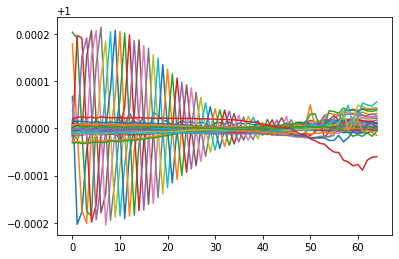

In [47]:
for i in range(64):
    plt.plot(threepcf_tcx.meand2[i,:,0]/np.mean(threepcf_tcx.meand2[i,:,0]))
np.mean(threepcf_tcx.meand2[1:,:,0],axis=1)/np.mean(threepcf_tcx.meand2[:-1,:,0],axis=1)

In [59]:
slicsfullreso.pos1

array([151.62956  , 399.98856  , 488.29962  , ...,  53.293072 ,
         5.6541085, 239.81259  ])

In [56]:
from scipy.spatial import cKDTree

In [82]:
slicstree = cKDTree(data=np.array([slicsfullreso.pos1, slicsfullreso.pos2]).transpose())

In [87]:
slicstree.query_ball_point(x=[slicsfullreso.pos1[12000],slicsfullreso.pos2[12000]], r=.5)

[2110116, 12000]

In [67]:
slicstree.size

524287

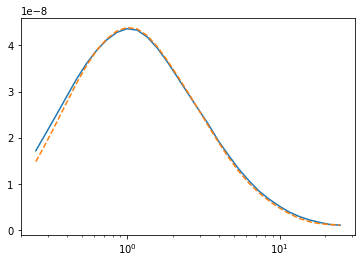

(0.96, 1.04)

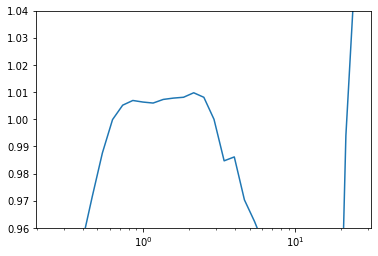

In [9]:
plt.semilogx(map3R, map3_direct, label="Direct")
plt.semilogx(map3R, np.sqrt(2)*map3_tcfromorpheus[0], ls="--", label="2 * Orpheus in SAS")
plt.show()
plt.semilogx(map3R, np.sqrt(2)*map3_tcfromorpheus[0]/map3_direct, label="Orpheus using JBJ integral")
plt.ylim(0.96,1.04)

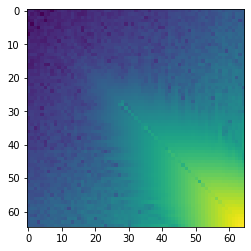

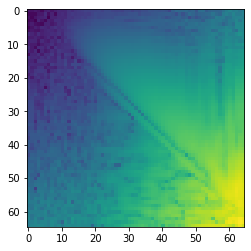

(4, 31, 1, 65, 65)

In [10]:
plt.imshow(np.log10(np.abs(threepcf_orpheus_noec.npcf_multipoles_norm[3,0])))
plt.show()

plt.imshow(np.log10(np.abs(threepcf_orpheus_noec.npcf_multipoles[1,3,0])))
plt.show()
threepcf_orpheus_noec.npcf_multipoles.shape

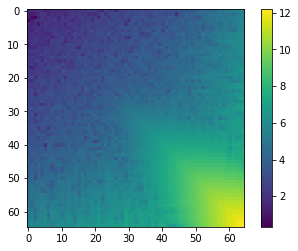

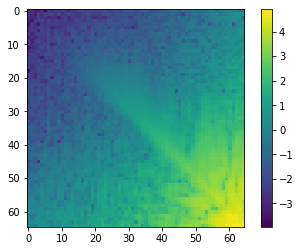

(4, 31, 125, 65, 65)

In [65]:
plt.imshow(np.log10(np.abs(threepcf_orpheus_noec.npcf_multipoles_norm[3,-12])))
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(threepcf_orpheus_noec.npcf_multipoles[3,4,119])))
plt.colorbar()
plt.show()
threepcf_orpheus_noec.npcf_multipoles.shape

000 1 (8, 31)


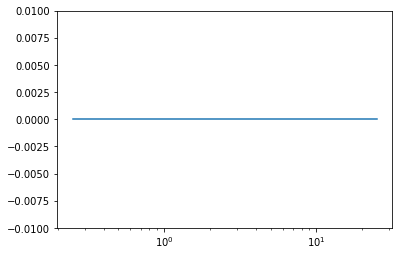

001 3 (8, 31)


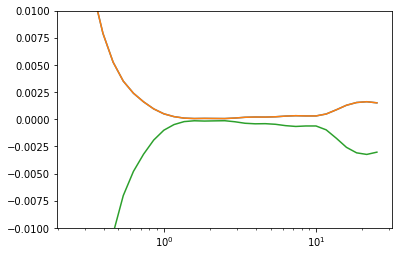

002 3 (8, 31)


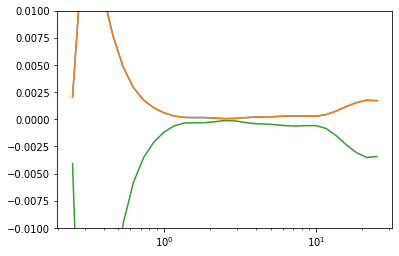

003 3 (8, 31)


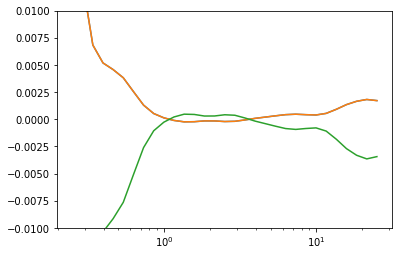

004 3 (8, 31)


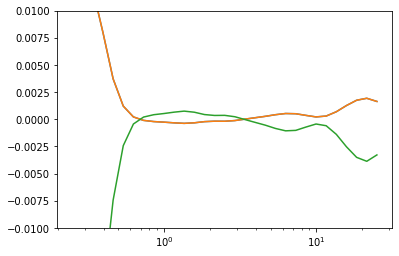

011 3 (8, 31)


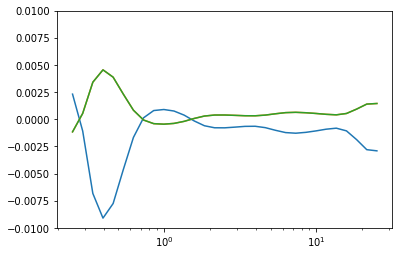

012 6 (8, 31)


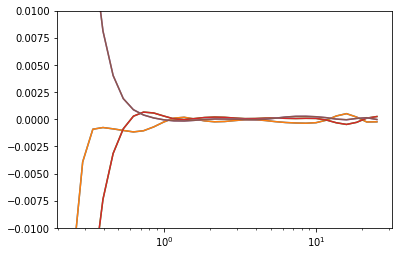

013 6 (8, 31)


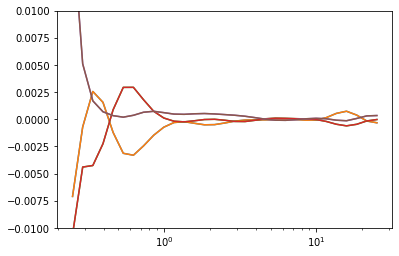

014 6 (8, 31)


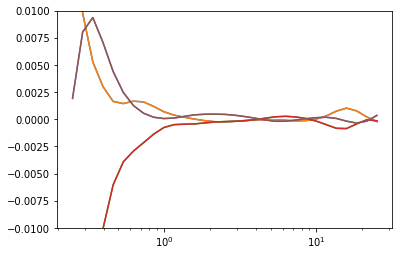

022 3 (8, 31)


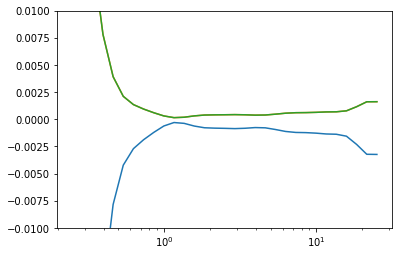

023 6 (8, 31)


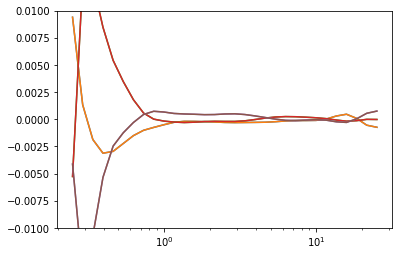

024 6 (8, 31)


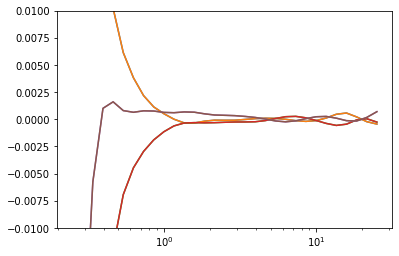

033 3 (8, 31)


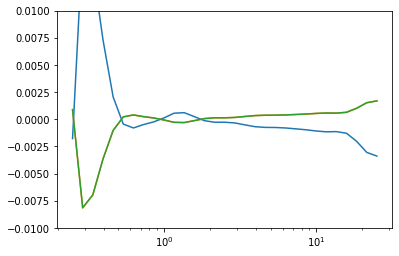

034 6 (8, 31)


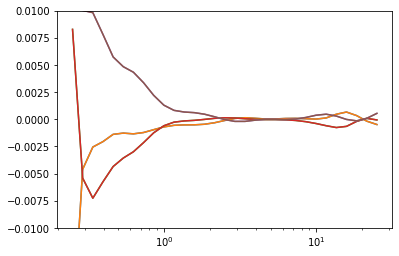

044 3 (8, 31)


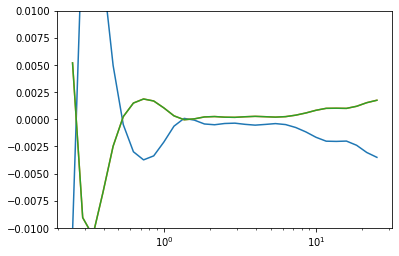

111 1 (8, 31)


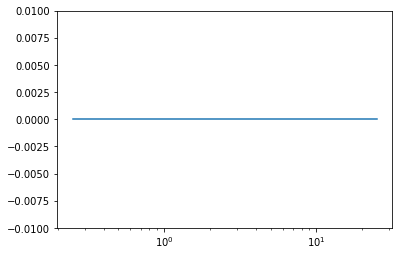

112 3 (8, 31)


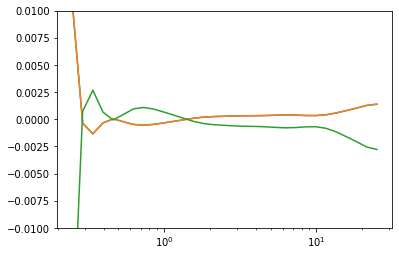

113 3 (8, 31)


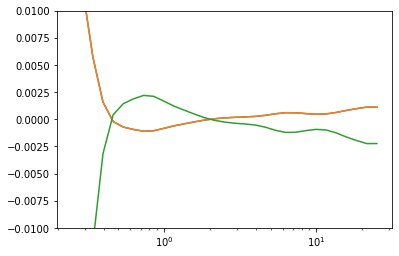

114 3 (8, 31)


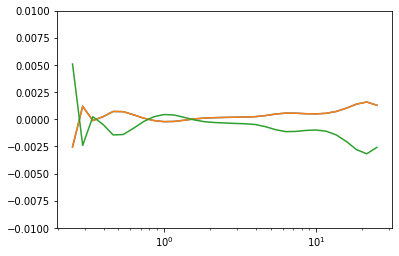

122 3 (8, 31)


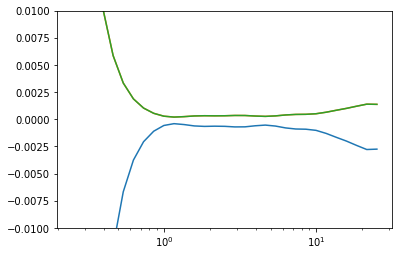

123 6 (8, 31)


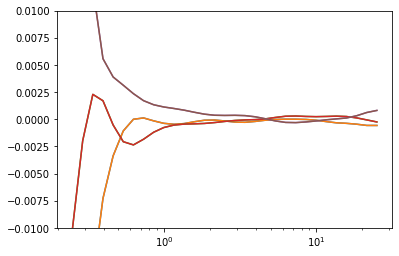

124 6 (8, 31)


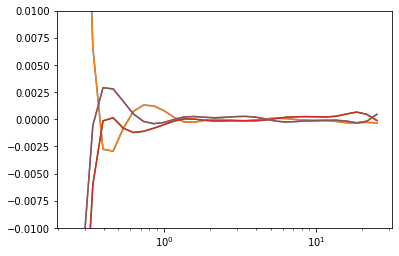

133 3 (8, 31)


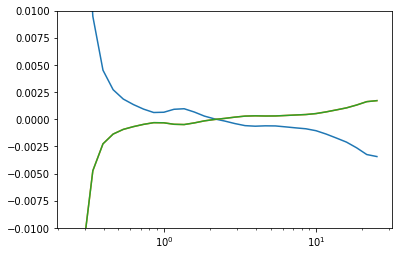

134 6 (8, 31)


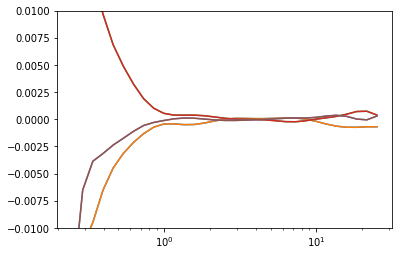

144 3 (8, 31)


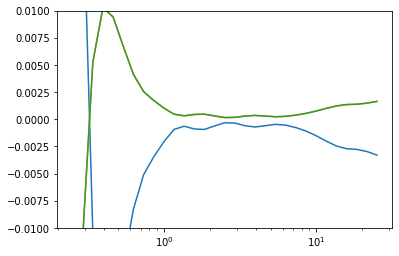

222 1 (8, 31)


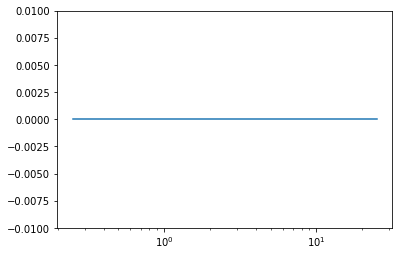

223 3 (8, 31)


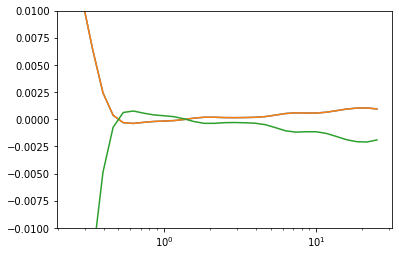

224 3 (8, 31)


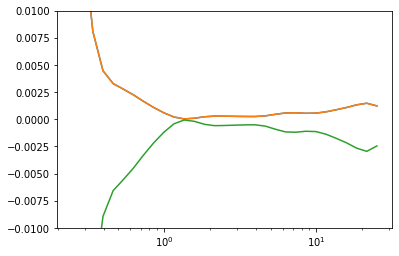

233 3 (8, 31)


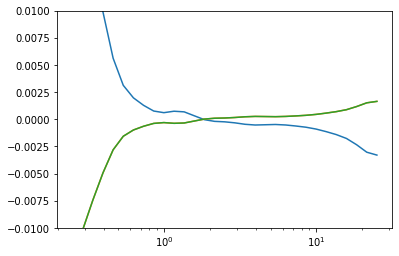

234 6 (8, 31)


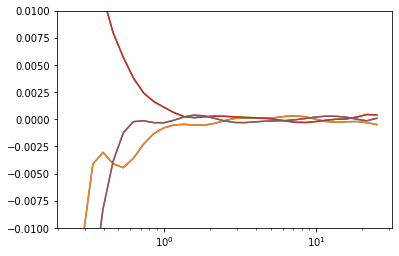

244 3 (8, 31)


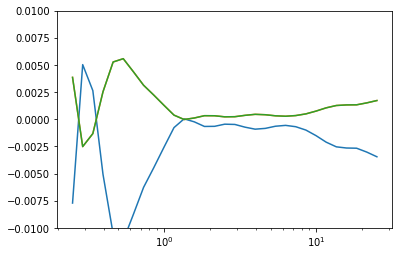

333 1 (8, 31)


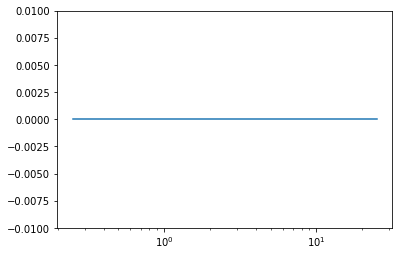

334 3 (8, 31)


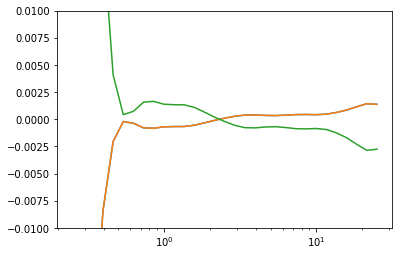

344 3 (8, 31)


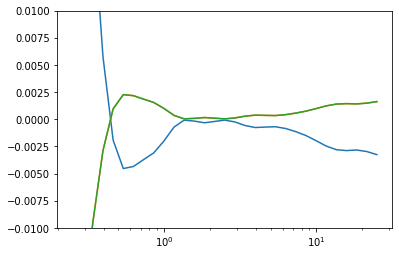

444 1 (8, 31)


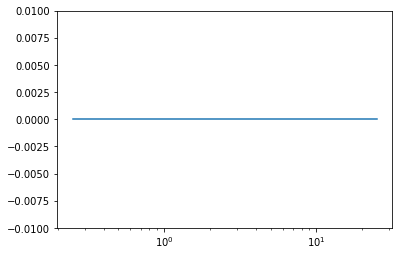

In [40]:
allztriplets = {}
for i in range(125):
    elz1 = i//25
    elz2 = (i-elz1*25)//5
    elz3 = i-elz1*25-elz2*5
    zkey = np.sort([elz1,elz2,elz3])
    zstr = str(zkey[0])+str(zkey[1])+str(zkey[2])
    if zstr not in allztriplets.keys():
        allztriplets[zstr] = []
    allztriplets[zstr].append(map3_orpheus_noec[:,i])
for zstr in allztriplets.keys():
    meanmap3zcombi = np.mean(np.asarray(allztriplets[zstr]),axis=0).real
    print(zstr, len(allztriplets[zstr]), meanmap3zcombi.shape)
    for map3zcombi in allztriplets[zstr]:
        plt.semilogx(map3R ,map3zcombi[0].real/meanmap3zcombi[0]-1)
    plt.ylim(-.01,.01)
    plt.show()